In [7]:
import torch                       #Import torch
import numpy as np                 #Import numpy
import pandas as pd                #Import pandas
import torch.nn as nn              #Import nural network              
import torch.nn.functional as F    #Import nural network functional for constructing model
import matplotlib.pyplot as plt    #Import matplotlib for visualization
% matplotlib inline

In [11]:
from torchvision import datasets               # Import the datasets
import torchvision.transforms as transforms    # transforms is utilize for flattening the image and to transform in tensor  
from torch.utils.data.sampler import SubsetRandomSampler# Import random Sampler from torch.utils.data.sampler

# No. of subprocess for loading data
no_workers=0
#set no of batch size
batch_size=20
#set no of validation set
valid_no=0.2

#convert the data to torch.floatTensor
transform=transforms.ToTensor()

#load the train and test data
train_data=datasets.MNIST(root='data',download=True, train=True,transform=transform)

test_data=datasets.MNIST(root='data',download=True, train=False,transform=transform)

#obtain the train indices and test indices

num_train=len(train_data)
indices=list(range(num_train))
split=int(np.floor(valid_no*num_train))
train_indx,validation_indx= indices[split:],indices[:split]

#define sampler for the test and validation index

train_sampler=SubsetRandomSampler(train_indx)
valid_sampler=SubsetRandomSampler(validation_indx)

#load the data in the variables using dataloader
train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                         sampler=train_sampler, num_workers=no_workers)
validation_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=valid_sampler, num_workers=no_workers)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=no_workers)


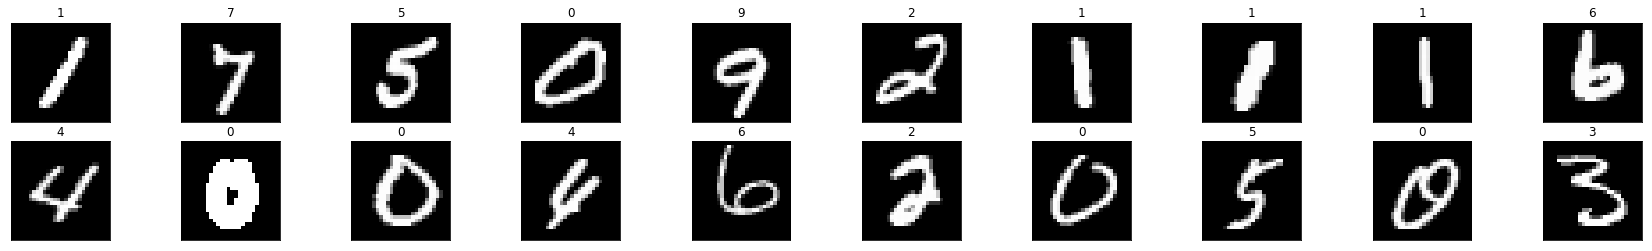

In [30]:
# to obtain a image in the first batch through dataiter

dataiter=iter(train_loader)
images, labels=dataiter.next()
images=images.numpy()

# to plot the images  in batch along with the labels
fig=plt.figure(figsize=(30,4))
for idx in np.arange(20):
    #plot subplot
    ax=fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())

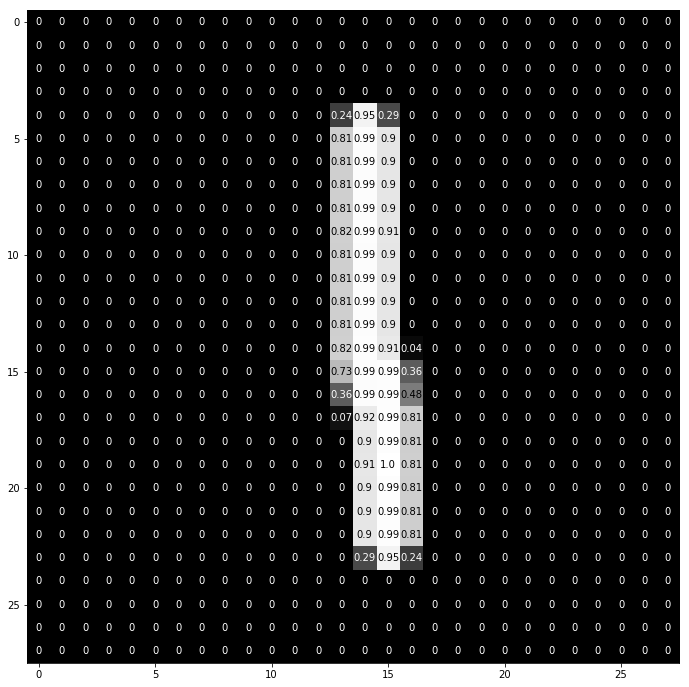

In [35]:
#detailing of single image

img=np.squeeze(images[8])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


In [37]:
# Define the network

class Network(nn.Module):
    def __init__(self):
        super(Network,self). __init__()
        #set a number of hidden layers 1 and 2
        hidden_1=512
        hidden_2=512
        #Create a linear layer 784 and hidden_1
        self.fc1=nn.Linear(784,hidden_1)
        #Create a linear layer hidden_1 and hidden_2
        self.fc2=nn.Linear(hidden_1,hidden_2)
        #Create a linear layer hidden_2 and output of 10
        self.fc3=nn.Linear(hidden_2,10)
        #Mention Dropout
        self.dropout=nn.Dropout(0.2)
        
    def forward(self,x):
        #flatten the image
        x=x.view(-1,28*28)
        #pass through ReLU function by using nn.functional as "F"
        x=F.relu(self.fc1(x))
        #add dropout layar
        x=self.dropout(x)
        #pass through second ReLU function
        x=F.relu(self.fc2(x))
        #add dropout layer
        x=self.dropout(x)
        #add output layer
        x=self.fc3(x)
        return x
    
# initialize nural network
model=Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [42]:
# define the cross entropy loss
criterion=nn.CrossEntropyLoss()

# define the optimizer ((stochastic gradient descent))and learning rate =0.01
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)


In [64]:
# train the model
# define the number of epochs

no_epochs=50

# se the validation loss to minimum infinity
validation_loss_min=np.Inf


#trin the model
for epochs in range(no_epochs):
    
    train_loss=0.0
    validation_loss=0.0
    
    ########################
    ###Training of Model###
    #######################
    model.train()# prepare model for training
    for data, target in train_loader:
        
        #optimize the zero gradiant
        optimizer.zero_grad()
        
        #forword pass: compute the prediction by passing through the model
        output=model(data)
        
        #calculate the loss
        loss=criterion(output,target)
        
        #compute the gradient of the loss and pass through the model again
        loss.backward()
        
        # wpdate the parameters using the single optimizer step
        optimizer.step()
        
        #update the running training loss
        train_loss +=loss.item()*data.size(0)
        
        
    ##############################
    ###validation of the model####
    ##############################
    model.eval()
    for data, target in validation_loader:
        output=model(data)
        
        loss=criterion(output, target)
        
        validation_loss += loss.item() *data.size(0)
    
    
    train_loss= train_loss/len(train_loader.dataset)
    validation_loss= validation_loss/len(validation_loader)
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epochs+1, 
        train_loss,
        validation_loss
        ))
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model.pt')
        validation_loss_min = validation_loss

Epoch: 1 	Training Loss: 0.128168 	Validation Loss: 2.802641
Validation loss decreased (inf --> 2.802641).  Saving model ...
Epoch: 2 	Training Loss: 0.113948 	Validation Loss: 2.549630
Validation loss decreased (2.802641 --> 2.549630).  Saving model ...
Epoch: 3 	Training Loss: 0.101527 	Validation Loss: 2.362450
Validation loss decreased (2.549630 --> 2.362450).  Saving model ...
Epoch: 4 	Training Loss: 0.093037 	Validation Loss: 2.194993
Validation loss decreased (2.362450 --> 2.194993).  Saving model ...
Epoch: 5 	Training Loss: 0.084879 	Validation Loss: 2.195178
Epoch: 6 	Training Loss: 0.077463 	Validation Loss: 1.939973
Validation loss decreased (2.194993 --> 1.939973).  Saving model ...
Epoch: 7 	Training Loss: 0.071896 	Validation Loss: 1.885833
Validation loss decreased (1.939973 --> 1.885833).  Saving model ...
Epoch: 8 	Training Loss: 0.066580 	Validation Loss: 1.848928
Validation loss decreased (1.885833 --> 1.848928).  Saving model ...
Epoch: 9 	Training Loss: 0.062781 

In [65]:
model.load_state_dict(torch.load('model.pt'))

In [66]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059131

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9823/10000)


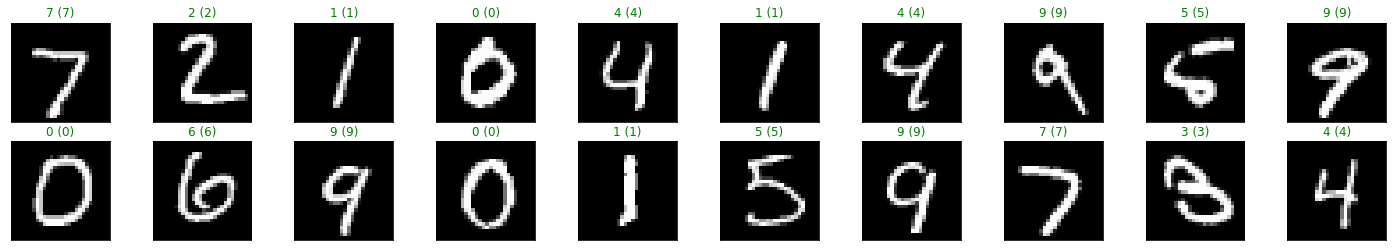

In [67]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))